In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import zipfile

zip_path = '/content/drive/MyDrive/complaints.zip'
extract_to = '/content/complaints'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Extracted successfully!")


Extracted successfully!


In [ ]:
import os

os.listdir('/content/complaints')


['complaints', '__MACOSX']

In [ ]:
import os

os.listdir('/content/complaints/complaints')


['consumercomplaints.csv']

In [ ]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
df = pd.read_csv('/content/complaints/complaints/consumercomplaints.csv')
df.head()


,Unnamed: 0,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative
0,0,2022-11-11,Mortgage,Conventional home mortgage,Trouble during payment process,NaN,NaN
1,1,2022-11-23,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN
2,2,2022-11-16,Mortgage,VA mortgage,Trouble during payment process,NaN,NaN
3,3,2022-11-15,Checking or savings account,Checking account,Managing an account,Fee problem,"Hi, I have been banking with Wells Fargo for o..."
4,4,2022-11-07,Mortgage,Other type of mortgage,Trouble during payment process,NaN,NaN


In [ ]:
df = df.drop("Unnamed: 0",axis=1)

In [ ]:
print(df.isnull().sum())

Unnamed: 0                            0
Date received                         0
Product                               0
Sub-product                      235294
Issue                                 0
Sub-issue                        683355
Consumer complaint narrative    1987977
dtype: int64


In [ ]:
df = df.dropna(subset=['Consumer complaint narrative'])

In [ ]:
print(df["Product"].value_counts())

Product
Credit reporting, credit repair services, or other personal consumer reports    515503
Debt collection                                                                 192045
Mortgage                                                                         97783
Credit card or prepaid card                                                      81866
Checking or savings account                                                      54264
Student loan                                                                     32713
Credit reporting                                                                 31588
Money transfer, virtual currency, or money service                               26578
Vehicle loan or lease                                                            19886
Credit card                                                                      18838
Bank account or service                                                          14885
Payday loan, title loan, or persona

In [ ]:
# Step 1: Merge duplicate categories
merge_map = {
    "Credit card or prepaid card": "Credit card / Prepaid card",
    "Credit card": "Credit card / Prepaid card",
    "Prepaid card": "Credit card / Prepaid card",

    "Money transfer, virtual currency, or money service": "Money transfer / Virtual currency",
    "Money transfers": "Money transfer / Virtual currency",
    "Virtual currency": "Money transfer / Virtual currency",

    "Bank account or service": "Bank account",
    "Checking or savings account": "Bank account",

    "Credit reporting": "Credit reporting, credit repair services, or other personal consumer reports",
    "Payday loan": "Loan",
    'Student loan': 'Loan',
    'Vehicle loan or lease': 'Loan',
    'Payday loan, title loan, or personal loan': 'Loan',
    'Consumer Loan': 'Loan'
}

df["Product"] = df["Product"].replace(merge_map)
df = df[df['Product'] != 'Other financial service']

print(df["Product"].value_counts())

Product
Credit reporting, credit repair services, or other personal consumer reports    547091
Debt collection                                                                 192045
Credit card / Prepaid card                                                      102154
Mortgage                                                                         97783
Loan                                                                             77387
Bank account                                                                     69149
Money transfer / Virtual currency                                                28091
Name: count, dtype: int64


In [ ]:
stopword = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean(text):
    text = str(text).lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stopword]
    lemmatized = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(lemmatized)

df["clean_text"] = df["Consumer complaint narrative"].apply(clean)


In [ ]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

X = df['clean_text']
y = df['Product']

print("Before balancing:\n", Counter(y))

TARGET_SIZE = 100000  # final balanced sample size per class

# 1. Undersample large ones
under_strategy = {cls: min(count, TARGET_SIZE) for cls, count in Counter(y).items()}
rus = RandomUnderSampler(sampling_strategy=under_strategy, random_state=42)
X_under, y_under = rus.fit_resample(X.values.reshape(-1, 1), y)

# 2. Oversample smaller ones
over_strategy = {cls: TARGET_SIZE for cls, count in Counter(y_under).items()}
ros = RandomOverSampler(sampling_strategy=over_strategy, random_state=42)
X_balanced, y_balanced = ros.fit_resample(X_under, y_under)

balanced_df = pd.DataFrame({'clean_text': X_balanced.flatten(), 'Product': y_balanced})

print("\nAfter balancing:\n", balanced_df['Product'].value_counts())


Before balancing:
 Counter({'Credit reporting, credit repair services, or other personal consumer reports': 547091, 'Debt collection': 192045, 'Credit card / Prepaid card': 102154, 'Mortgage': 97783, 'Loan': 77387, 'Bank account': 69149, 'Money transfer / Virtual currency': 28091})

After balancing:
 Product
Bank account                                                                    100000
Credit card / Prepaid card                                                      100000
Credit reporting, credit repair services, or other personal consumer reports    100000
Debt collection                                                                 100000
Loan                                                                            100000
Money transfer / Virtual currency                                               100000
Mortgage                                                                        100000
Name: count, dtype: int64


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    balanced_df['clean_text'], balanced_df['Product'],
    test_size=0.2, random_state=42, stratify=balanced_df['Product']
)


X_text = np.array(df["clean_text"])
y = np.array(df["Product"])


tfidf = TfidfVectorizer(max_features=20000,
    ngram_range=(1, 2),
    sublinear_tf=True,
    min_df=2,
    max_df=0.9)


X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [ ]:
model = SGDClassifier(
    loss='log_loss',          # for probabilistic outputs
    penalty='elasticnet',     # handles both L1 and L2 regularization
    alpha=1e-5,               # regularization strength
    max_iter=1000,
    early_stopping=True,      # <-- enables early stopping
    validation_fraction=0.1,  # 10% of training data for validation
    n_iter_no_change=5,       # stop if no improvement for 5 epochs
    random_state=42
)

model.fit(X_train_tfidf, y_train)

SGDClassifier(alpha=1e-05, early_stopping=True, loss='log_loss',
              penalty='elasticnet', random_state=42)

In [ ]:
y_pred = model.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8463857142857143
Precision: 0.8464972920077387
Recall: 0.8463857142857143
F1 Score: 0.8463935089564739

Classification Report:
                                                                               precision    recall  f1-score   support

                                                                Bank account       0.81      0.82      0.81     20000
                                                  Credit card / Prepaid card       0.82      0.83      0.83     20000
Credit reporting, credit repair services, or other personal consumer reports       0.82      0.82      0.82     20000
                                                             Debt collection       0.82      0.82      0.82     20000
                                                                        Loan       0.85      0.85      0.85     20000
                                           Money transfer / Virtual currency       0.87      0.84      0.85     20000
                                 

In [ ]:
user = input("Enter a Text: ")
cleaned_user = clean(user)
data_input = tfidf.transform([cleaned_user])

# Get predicted probabilities
probs = model.predict_proba(data_input)
max_prob = probs.max()

threshold = 0.4  # tune this
if max_prob < threshold:
    print("Predicted Category: Please enter a valid complaint!!!")
else:
    output = model.classes_[probs.argmax()]
    print("Predicted Category:", output)


Enter a Text: i had transfer money from my bank account to my sister's account. But the transfer was not successful at all.
Predicted Category: Money transfer / Virtual currency


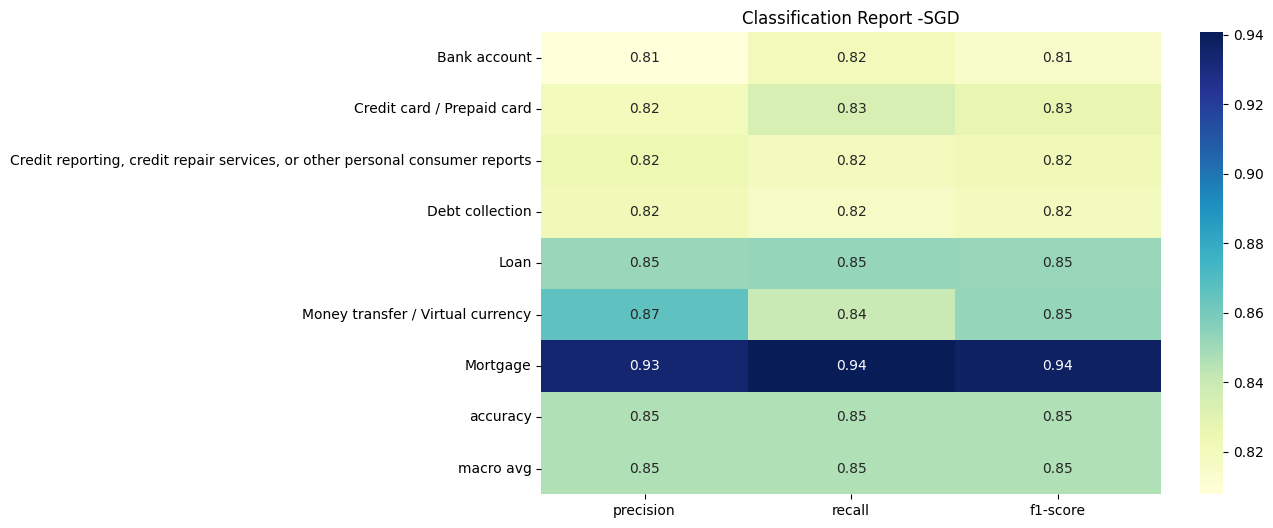

In [ ]:
from sklearn.metrics import classification_report
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

report = classification_report(y_test, y_pred, output_dict=True)
df = pd.DataFrame(report).transpose()

plt.figure(figsize=(10, 6))
sns.heatmap(df.iloc[:-1, :-1], annot=True, cmap='YlGnBu')
plt.title("Classification Report -SGD")
plt.show()

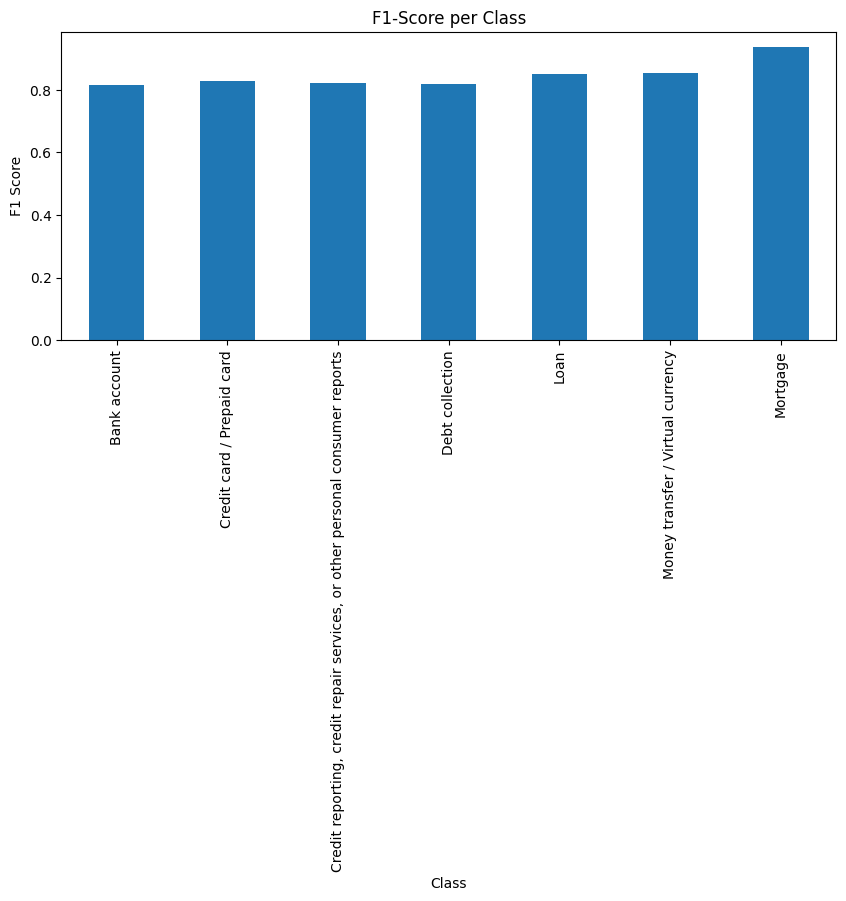

In [ ]:
f1_scores = df['f1-score'].iloc[:-3]  # excluding avg rows
f1_scores.plot(kind='bar', figsize=(10,4))
plt.title("F1-Score per Class")
plt.ylabel("F1 Score")
plt.xlabel("Class")
plt.xticks(rotation=90)
plt.show()


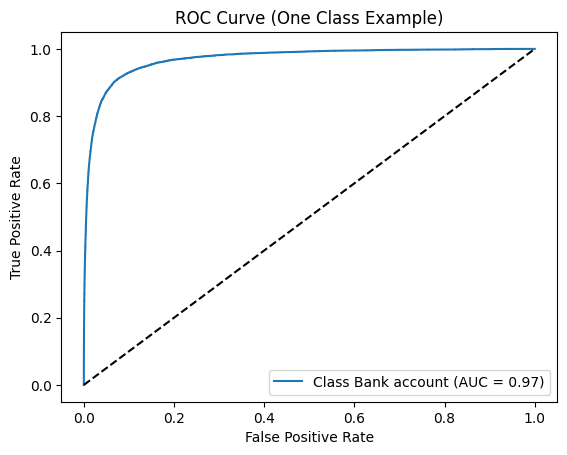

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize output
y_test_bin = label_binarize(y_test, classes=model.classes_)
y_score = model.predict_proba(X_test_tfidf)

# Plot ROC for first class (repeat for others)
fpr, tpr, _ = roc_curve(y_test_bin[:, 0], y_score[:, 0])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'Class {model.classes_[0]} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One Class Example)")
plt.legend()
plt.show()

Epoch 1: Train Accuracy=0.8506, Test Accuracy=0.8463
Epoch 2: Train Accuracy=0.8506, Test Accuracy=0.8463
Epoch 3: Train Accuracy=0.8507, Test Accuracy=0.8463
Epoch 4: Train Accuracy=0.8507, Test Accuracy=0.8464
Epoch 5: Train Accuracy=0.8507, Test Accuracy=0.8464
Epoch 6: Train Accuracy=0.8507, Test Accuracy=0.8465
Epoch 7: Train Accuracy=0.8508, Test Accuracy=0.8465
Epoch 8: Train Accuracy=0.8508, Test Accuracy=0.8465
Epoch 9: Train Accuracy=0.8508, Test Accuracy=0.8465
Epoch 10: Train Accuracy=0.8508, Test Accuracy=0.8466
Epoch 11: Train Accuracy=0.8508, Test Accuracy=0.8466
Epoch 12: Train Accuracy=0.8508, Test Accuracy=0.8466
Epoch 13: Train Accuracy=0.8508, Test Accuracy=0.8466
Epoch 14: Train Accuracy=0.8508, Test Accuracy=0.8466
Epoch 15: Train Accuracy=0.8508, Test Accuracy=0.8466
Epoch 16: Train Accuracy=0.8508, Test Accuracy=0.8466
Epoch 17: Train Accuracy=0.8508, Test Accuracy=0.8467
Epoch 18: Train Accuracy=0.8508, Test Accuracy=0.8467
Epoch 19: Train Accuracy=0.8508, Test

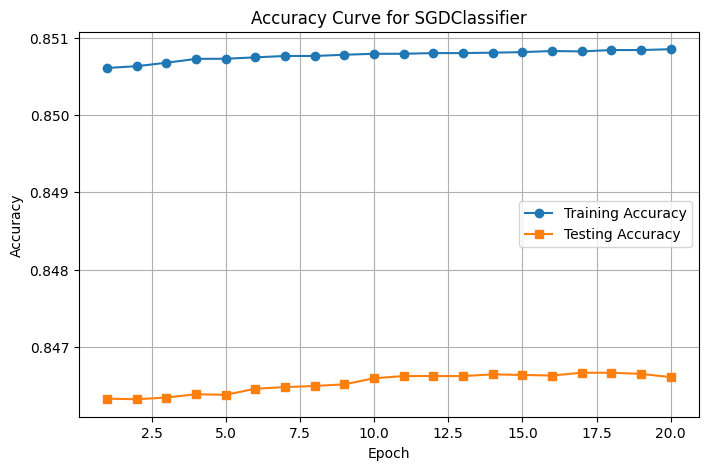

In [ ]:
# Manual training using partial_fit to track accuracy
classes = np.unique(y_train)
train_accuracies = []
test_accuracies = []

for epoch in range(1, 21):  # run for 20 epochs
    model.partial_fit(X_train_tfidf, y_train, classes=classes)

    # Compute accuracy each epoch
    train_acc = accuracy_score(y_train, model.predict(X_train_tfidf))
    test_acc = accuracy_score(y_test, model.predict(X_test_tfidf))
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch}: Train Accuracy={train_acc:.4f}, Test Accuracy={test_acc:.4f}")

# Plot accuracy curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 21), train_accuracies, marker='o', label='Training Accuracy')
plt.plot(range(1, 21), test_accuracies, marker='s', label='Testing Accuracy')
plt.title('Accuracy Curve for SGDClassifier')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()